<a href="https://colab.research.google.com/github/young-hwanlee/my-practical-statistics-for-data-scientists/blob/main/Chapter_7_Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # Clone the repository
# !git clone https://github.com/young-hwanlee/practical-statistics-for-data-scientists.git

# # Open the file from the list of contents (File)
# # Then, copy and paste it

## Practical Statistics for Data Scientists (Python)
## Chapter 7. Unsupervised Learning
> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

Import required Python packages.

In [3]:
!pip install prince

In [4]:
import math
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import multivariate_normal

import prince

import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import from_levels_and_colors
import seaborn as sns

%matplotlib inline
print()

In [5]:
# try:
#     import common
#     DATA = common.dataDirectory()
# except ImportError:
#     DATA = Path().resolve() / 'data'

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [6]:
# SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'
# SP500_SECTORS_CSV = DATA / 'sp500_sectors.csv'
# LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'
# HOUSE_TASKS_CSV = DATA / 'housetasks.csv'

DATA = 'https://raw.githubusercontent.com/young-hwanlee/practical-statistics-for-data-scientists/master/data/'

SP500_DATA_CSV = DATA + 'sp500_data.csv.gz'
SP500_SECTORS_CSV = DATA + 'sp500_sectors.csv'
LOAN_DATA_CSV = DATA + 'loan_data.csv.gz'
HOUSE_TASKS_CSV = DATA + 'housetasks.csv'

## **7.1 Principal Components Analysis**
### **7.1.1 A simple example**

In [7]:
sp500_px = pd.read_csv(SP500_DATA_CSV, index_col=0)
oil_px = sp500_px[['XOM', 'CVX']]
print(oil_px.head())

                 XOM       CVX
1993-01-29 -0.016991  0.072921
1993-02-01  0.016991  0.102089
1993-02-02  0.084954  0.029168
1993-02-03  0.067964  0.058337
1993-02-04  0.034378  0.044272


In [8]:
pcs = PCA(n_components=2)
pcs.fit(oil_px)
loadings = pd.DataFrame(pcs.components_, columns=oil_px.columns)
print(loadings)

        XOM       CVX
0 -0.664711 -0.747101
1  0.747101 -0.664711


In [9]:
def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

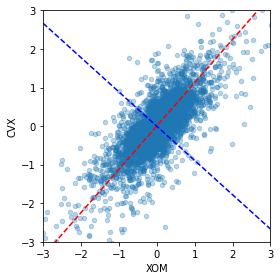

In [11]:
ax = oil_px.plot.scatter(x='XOM', y='CVX', alpha=0.3, figsize=(4, 4))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

# ax.plot(*abline(loadings.loc[0, 'CVX'] / loadings.loc[0, 'XOM'], 0, ax),
#         '--', color='C1')
# ax.plot(*abline(loadings.loc[1, 'CVX'] / loadings.loc[1, 'XOM'], 0, ax),
#         '--', color='C1)
ax.plot(*abline(loadings.loc[0, 'CVX'] / loadings.loc[0, 'XOM'], 0, ax),
        '--', color='r')
ax.plot(*abline(loadings.loc[1, 'CVX'] / loadings.loc[1, 'XOM'], 0, ax),
        '--', color='b')

plt.tight_layout()
plt.show()

### **7.1.3 Interpreting principal components**

In [13]:
sp500_px

,ADS,CA,MSFT,RHT,CTSH,CSC,EMC,IBM,XRX,ALTR,ADI,AVGO,BRCM,FSLR,INTC,LLTC,MCHP,MU,NVDA,QRVO,QCOM,SWKS,TXN,XLNX,AAPL,HPQ,EA,SNDK,STX,WDC,TEL,HRS,MSI,ACN,AMAT,KLAC,LRCX,ADBE,ADSK,ORCL,...,ENDP,LLY,MNK,MRK,MYL,PRGO,PFE,ZTS,ABT,A,BCR,BAX,BDX,BSX,EW,HSP,ISRG,JNJ,MDT,PKI,STJ,SYK,TMO,VAR,ZBH,BMY,CAH,CERN,ESRX,MCK,WAT,ALXN,AMGN,BXLT,BIIB,CELG,GILD,REGN,VRTX,HSIC
1993-01-29,0.000000,0.060124,-0.022100,0.000000,0.000000,0.018897,0.007368,0.092165,0.259140,-0.007105,-0.015785,0.000000,0.000000,0.000000,-0.050488,-0.089870,0.000000,0.037021,0.000000,0.000000,-0.044718,-0.041262,0.060179,0.033152,-0.024235,0.045586,0.125000,0.000000,0.000000,0.118103,0.000000,0.016412,-1.842719,0.000000,-0.012867,0.079940,0.246706,-0.044884,0.057267,-0.005776,...,0.000000,-0.077535,0.000000,-0.028797,0.166355,-0.577943,0.066591,0.000000,0.045961,0.000000,-0.326659,0.000000,-0.033363,0.062500,0.000000,0.000000,0.000000,0.018827,0.006047,0.000000,0.187132,0.276317,-0.124187,0.037430,0.000000,0.038546,0.060142,0.031260,0.001950,0.000000,0.000000,0.000000,0.347160,0.000000,0.041670,0.000000,0.015564,1.750000,0.125000,0.000000
1993-02-01,0.000000,-0.180389,0.027621,0.000000,0.000000,0.018889,0.018425,0.115207,-0.100775,0.063893,-0.015793,0.000000,0.000000,0.000000,0.095367,0.044935,0.000000,0.037020,0.000000,0.000000,0.006387,-0.041252,0.102317,0.099446,0.064618,0.072942,0.093750,0.000000,0.000000,0.000000,0.000000,-0.032829,0.594428,0.000000,0.016077,0.019985,0.411170,0.134672,0.057267,0.025999,...,0.000000,-0.031014,0.000000,-0.172781,-0.066536,0.346766,-0.027745,0.000000,-0.045960,0.000000,-0.093331,0.018157,0.100076,0.031250,0.000000,0.000000,0.000000,-0.056481,-0.048392,0.041782,-0.074851,-0.027632,0.000000,-0.074859,0.000000,-0.038546,0.060142,0.101560,0.019530,0.000000,0.000000,0.000000,-0.231440,0.000000,0.000000,-0.010410,0.007782,1.250000,0.125000,0.000000
1993-02-02,0.000000,-0.120257,0.035900,0.000000,0.000000,-0.075573,0.029482,-0.023041,0.028796,-0.014192,0.047363,0.000000,0.000000,0.000000,0.000000,0.067402,0.000000,0.123402,0.000000,0.000000,0.035141,0.041252,-0.024066,0.016572,-0.016148,-0.045586,-0.062500,0.000000,0.000000,0.118103,0.000000,-0.032829,0.237767,0.000000,0.051450,0.000000,0.054828,0.082299,-0.042955,-0.011562,...,0.000000,-0.062028,0.000000,-0.143984,-0.066536,0.693532,-0.133183,0.000000,-0.153198,0.000000,-0.093331,-0.072626,0.000000,0.031250,0.000000,0.000000,0.000000,-0.018827,0.000000,0.208912,0.018711,-0.027632,0.000000,0.044923,0.000000,-0.115639,-0.030071,-0.015620,0.000000,0.000000,0.000000,0.000000,-0.115720,0.000000,0.000000,0.000000,-0.007792,-0.250000,0.000000,0.000000
1993-02-03,0.000000,0.060124,-0.024857,0.000000,0.000000,-0.151128,0.003689,-0.253454,-0.043190,-0.007105,0.205236,0.000000,0.000000,0.000000,-0.050495,0.022467,0.000000,-0.012340,0.000000,0.000000,0.006387,0.041252,-0.024073,0.049723,-0.032305,-0.091184,0.218750,0.000000,0.000000,0.059052,0.000000,0.049247,-0.118893,0.000000,0.000000,0.039970,-0.054828,-0.149639,0.057267,0.002884,...,0.000000,0.139564,0.000000,0.345561,0.133081,0.693532,0.022199,0.000000,0.168520,0.000000,0.093331,0.090783,0.044480,0.031250,0.000000,0.000000,0.000000,0.263578,0.030243,0.125347,0.187140,0.000000,0.124187,0.104805,0.000000,0.141333,0.000000,-0.011720,0.023440,0.000000,0.000000,0.000000,-0.086790,0.000000,0.041670,-0.041670,-0.038919,-0.500000,0.062500,0.000000
1993-02-04,0.000000,-0.360770,-0.060757,0.000000,0.000000,0.113350,-0.022114,0.069862,0.000000,-0.007096,-0.031570,0.000000,0.000000,0.000000,0.000000,0.022467,0.000000,-0.074041,0.000000,0.000000,0.051113,0.041252,-0.024073,-0.008290,-0.016157,-0.109414,0.093750,0.000000,0.000000,-0.118103,0.000000,0.000000,-0.237776,0.000000,-0.003219,-0.099925,-0.246706,0.000000,-0.157480,-0.017329,...,0.000000,0.000000,0.000000,-0.345561,-0.133073,-0.924709,-0.016648,0.000000,-0.061282,0.000000,0.186662,0.000000,-0.011123,-0.156250,0.000000,0.000000,0.000000,0.018827,-0.024196,0.167129,-0.187629,-0.082895,0.341510,-0.029946,0.000

In [14]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP',
               'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]
top_sp

,AAPL,AXP,COP,COST,CSCO,CVX,HD,INTC,JPM,MSFT,SLB,TGT,USB,WFC,WMT,XOM
2011-01-03,0.527368,0.093870,-0.336272,-0.240605,0.035704,0.240681,0.099184,-0.137211,0.512093,-0.061805,-0.325923,0.455646,-0.234866,0.250042,0.294839,0.736805
2011-01-04,-0.154321,-0.431788,-0.463161,-0.171859,0.008926,-0.584516,-0.541005,0.025726,0.335894,0.132440,-2.030049,-0.580720,-0.153566,0.000000,0.142951,0.168668
2011-01-05,0.597152,0.895406,-0.057104,-0.859307,0.169599,0.446985,-0.054099,-0.214392,0.689468,0.088294,1.536499,-0.482448,0.198732,0.857284,-0.303772,0.026631
2011-01-06,-0.132850,-0.612646,-0.463161,0.249200,0.035706,-0.919751,-0.189354,0.085757,0.070713,0.688689,-1.927614,-0.786210,-0.532962,0.000000,-0.312709,0.248558
2011-01-07,0.285820,-0.537242,-0.006350,-0.257788,0.098187,0.180511,-0.036064,-0.042878,-0.795539,-0.035317,0.931215,-0.089345,-0.171633,-0.651894,0.169758,0.337329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-06-25,-1.360001,-1.105863,-0.949997,-1.000000,-0.158775,-1.110001,-1.000000,-0.030000,-0.665647,-0.379997,-0.690003,0.080002,-0.238625,-0.580002,-0.589996,-0.919998
2015-06-26,-0.919998,-0.288920,0.029998,0.119996,-0.208393,0.360000,-0.169999,-0.490000,0.009930,-0.390004,0.279999,-0.409996,-0.020001,0.099999,0.160004,0.029999
2015-06-29,-0.930000,-1.414705,-0.410000,-1.319993,-0.446558,-0.809998,-1.019997,-0.310002,-0.476886,-0.670002,0.060006,-1.390007,-0.500000,-0.739998,-0.380005,-0.230003
2015-06-30,-0.140000,-0.449997,-0.119999,-1.320007,-0.367171,-0.979996,-0.020005,-0.209999,-0.129153,-0.559997,-0.189995,-1.020005,-0.439998,-0.299999,-0.879998,-0.540001


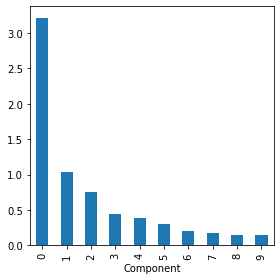

In [15]:
sp_pca = PCA()
sp_pca.fit(top_sp)

explained_variance = pd.DataFrame(sp_pca.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

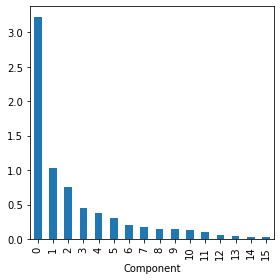

In [16]:
ax = explained_variance.plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

In [ ]:
loadings = pd.DataFrame(sp_pca.components_[0:5, :], 
                        columns=top_sp.columns)
print(loadings)

In [ ]:
maxPC = 1.01 * np.max(np.max(np.abs(loadings.loc[0:5, :])))

f, axes = plt.subplots(5, 1, figsize=(5, 5), sharex=True)

for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

### **7.1.4 Correspondence analysis**

In [ ]:
housetasks = pd.read_csv(HOUSE_TASKS_CSV, index_col=0)

ca = prince.CA(n_components=2)
ca = ca.fit(housetasks)

ca.plot_coordinates(housetasks, figsize=(6, 6))
plt.tight_layout()
plt.show()

## **7.2 K-Means Clustering**
### **7.2.1 A Simple Example**

In [ ]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
kmeans = KMeans(n_clusters=4).fit(df)
df['cluster'] = kmeans.labels_
print(df.head())

In [ ]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['XOM', 'CVX'])
print(centers)

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.scatterplot(x='XOM', y='CVX', hue='cluster', style='cluster', 
                     ax=ax, data=df)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
centers.plot.scatter(x='XOM', y='CVX', ax=ax, s=50, color='black')

plt.tight_layout()
plt.show()

### **7.2.2 K-Means Algorithm**
The _scikit-learn_ algorithm is repeated 10 times by default (`n_init`), `max_iter` is used to control the number of iterations.

In [ ]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP', 
               'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]
kmeans = KMeans(n_clusters=5).fit(top_sp)

### **7.2.3 Interpreting the Clusters**

In [ ]:
from collections import Counter
print(Counter(kmeans.labels_))

In [ ]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=syms)

f, axes = plt.subplots(5, 1, figsize=(5, 6), sharex=True)
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.01 * np.max(np.max(np.abs(center)))
    colors = ['C0' if l > 0 else 'C1' for l in center]
    ax.axhline(color='#888888')
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster {i + 1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

### **7.2.4 Selecting the Number of Clusters**

In [ ]:
inertia = []
for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(top_sp)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(2, 15), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

## **7.3 Hierarchical Clustering**
### **7.3.1 A Simple Example**

In [ ]:
syms1 = ['AAPL', 'AMZN', 'AXP', 'COP', 'COST', 'CSCO', 'CVX', 'GOOGL', 'HD', 
         'INTC', 'JPM', 'MSFT', 'SLB', 'TGT', 'USB', 'WFC', 'WMT', 'XOM']
df = sp500_px.loc[sp500_px.index >= '2011-01-01', syms1].transpose()

Z = linkage(df, method='complete')
print(Z.shape)

### **7.3.2 The Dendrogram**

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
dendrogram(Z, labels=list(df.index), color_threshold=0)
plt.xticks(rotation=90)
ax.set_ylabel('distance')

plt.tight_layout()
plt.show()

In [ ]:
memb = fcluster(Z, 4, criterion='maxclust')
memb = pd.Series(memb, index=df.index)
for key, item in memb.groupby(memb):
    print(f"{key} : {', '.join(item.index)}")

### **7.3.4 Measures of Dissimilarity**

In [ ]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
for i, method in enumerate(['single', 'average', 'complete', 'ward']):
    ax = axes[i // 2, i % 2]
    Z = linkage(df, method=method)
    colors = [f'C{c+1}' for c in fcluster(Z, 4, criterion='maxclust')]
    ax = sns.scatterplot(x='XOM', y='CVX', hue=colors, style=colors,
                         size=0.5, ax=ax, data=df, legend=False)

    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_title(method)

plt.tight_layout()
plt.show()

## **7.4 Model based clustering**
### **7.4.1 Multivariate Normal Distribution**
Define a colormap that corresponds to the probability levels.

In [ ]:
mean = [0.5, -0.5]
cov = [[1, 1], [1, 2]]
probability = [.5, .75, .95, .99]
def probLevel(p):
    D = 1
    return (1 - p) / (2 * math.pi * D)
levels = [probLevel(p) for p in probability]

fig, ax = plt.subplots(figsize=(5, 5))

x, y = np.mgrid[-2.8:3.8:.01, -5:4:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(mean, cov)


CS = ax.contourf(x, y, rv.pdf(pos), cmap=cm.GnBu, levels=50)
ax.contour(CS, levels=levels, colors=['black'])
ax.plot(*mean, color='black', marker='o')


plt.tight_layout()
plt.show()

### **7.4.2 Mixtures of Normals**

In [ ]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
mclust = GaussianMixture(n_components=2).fit(df)
print(mclust.bic(df))

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
colors = [f'C{c}' for c in mclust.predict(df)]
df.plot.scatter(x='XOM', y='CVX', c=colors, alpha=0.5, ax=ax)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

plt.tight_layout()
plt.show()

In [ ]:
print('Mean')
print(mclust.means_)
print('Covariances')
print(mclust.covariances_)

### **7.4.3 Selecting the number of clusters**

In [ ]:
results = []
covariance_types = ['full', 'tied', 'diag', 'spherical']
for n_components in range(1, 9):
    for covariance_type in covariance_types:
        mclust = GaussianMixture(n_components = n_components, warm_start=True,
                                 covariance_type = covariance_type)
        mclust.fit(df)
        results.append({
            'bic': mclust.bic(df),
            'n_components': n_components,
            'covariance_type': covariance_type,
        })
        
results = pd.DataFrame(results)

colors = ['C0', 'C1', 'C2', 'C3']
styles = ['C0-','C1:','C0-.', 'C1--']

fig, ax = plt.subplots(figsize=(4, 4))
for i, covariance_type in enumerate(covariance_types):
    subset = results.loc[results.covariance_type == covariance_type, :]
    subset.plot(x='n_components', y='bic', ax=ax, label=covariance_type, 
                kind='line', style=styles[i]) # , color=colors[i])

plt.tight_layout()
plt.show()

## **7.5 Scaling and Categorical Variables**
### **7.5.1 Scaling the Variables**

In [ ]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)
defaults = loan_data.loc[loan_data['outcome'] == 'default',]

columns = ['loan_amnt', 'annual_inc', 'revol_bal', 'open_acc', 
           'dti', 'revol_util']

df = defaults[columns]
kmeans = KMeans(n_clusters=4, random_state=1).fit(df)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=columns)
centers['size'] = [counts[i] for i in range(4)]
print(centers)

In [ ]:
scaler = preprocessing.StandardScaler()
df0 = scaler.fit_transform(df * 1.0)

kmeans = KMeans(n_clusters=4, random_state=1).fit(df0)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                       columns=columns)
centers['size'] = [counts[i] for i in range(4)]
print(centers)

### **7.5.2 Dominant Variables**

In [ ]:
syms = ['GOOGL', 'AMZN', 'AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 
        'SLB', 'COP', 'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST']
top_sp1 = sp500_px.loc[sp500_px.index >= '2005-01-01', syms]

sp_pca1 = PCA()
sp_pca1.fit(top_sp1)

explained_variance = pd.DataFrame(sp_pca1.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

In [ ]:
loadings = pd.DataFrame(sp_pca1.components_[0:2, :], 
                        columns=top_sp1.columns)
print(loadings.transpose())

### **7.5.3 Categorical Data and Gower's Distance**
Currently not available in any of the standard packages. However work is in progress to add it to scikit-learn. We will update this notebook once it becomes available.  
https://github.com/scikit-learn/scikit-learn/pull/9555/

In [ ]:
x = defaults[['dti', 'payment_inc_ratio', 'home_', 'purpose_']].loc[0:4, :]
print(x)

```
###############################################################
## Figure 7-13: Categorical data and Gower's distance

x <- loan_data[1:5, c('dti', 'payment_inc_ratio', 'home_', 'purpose_')]
x

daisy(x, metric='gower')

set.seed(301)
df <- loan_data[sample(nrow(loan_data), 250),
                c('dti', 'payment_inc_ratio', 'home_', 'purpose_')]
d = daisy(df, metric='gower')
hcl <- hclust(d)
dnd <- as.dendrogram(hcl)

png(filename=file.path(PSDS_PATH, 'figures', 'psds_0713.png'), width = 4, height=4, units='in', res=300)
par(mar=c(0,5,0,0)+.1)
plot(dnd, leaflab='none', ylab='distance')
dev.off()

dnd_cut <- cut(dnd, h=.5)
df[labels(dnd_cut$lower[[1]]),]


## Problems in clustering with mixed data types
df <- model.matrix(~ -1 + dti + payment_inc_ratio + home_ + pub_rec_zero, data=defaults)
df0 <- scale(df)
km0 <- kmeans(df0, centers=4, nstart=10)
centers0 <- scale(km0$centers, center=FALSE, scale=1/attr(df0, 'scaled:scale'))
round(scale(centers0, center=-attr(df0, 'scaled:center'), scale=FALSE), 2)
```

### **7.5.4 Problems with Clustering Mixed Data**

In [ ]:
columns = ['dti', 'payment_inc_ratio', 'home_', 'pub_rec_zero']
df = pd.get_dummies(defaults[columns])

scaler = preprocessing.StandardScaler()

df0 = scaler.fit_transform(df * 1.0)
kmeans = KMeans(n_clusters=4, random_state=1).fit(df0)
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                       columns=df.columns)
print(centers)